# Importing the right libraries


In [ ]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA

# Own modules in /src/
from neural_networks.rbf_layer import RBFLayer, InitCentersRandom
from utility.stats import check_stationarity
from utility.utils import compute_trend_target_on_dataframe
from filters.unscented_kalman_filter import UnscentedKalmanFilter
from backtest.metrics import drawdown
from backtest.reports import plot_from_trade_df,print_portfolio_strategy_report


# Load the data (once)

## Reading the files


In [ ]:
df = pd.read_excel(
    "../data/APPLE.xlsx", sheet_name="Feuil1", names=["date", "prices"], skiprows=0
).iloc[-10000:]

df["returns"] = df["prices"].pct_change()
df["returns_1H"] = df["prices"].pct_change(60)
df["returns_2H"] = df["prices"].pct_change(60 * 2)
df["returns_5H"] = df["prices"].pct_change(60 * 5)
df["returns_24H"] = df["prices"].pct_change(60 * 24)
df["EMA_returns_24H"] = df["returns_24H"].ewm(span=100).mean()
df["returns_48H"] = df["prices"].pct_change(60 * 24 * 2)
# df["variance"] = df["returns"].rolling(100).var()

df["vol"] = (
    df["returns"].rolling(100).std().apply(lambda x: x * np.sqrt(252 * 60 * 6.5))
)
# df["volvol"] = df["vol"].rolling(100).std()
df["backward_linear_reg_1H"] = (
    df["prices"].rolling(60).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_2H"] = (
    df["prices"].rolling(60 * 2).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_5H"] = (
    df["prices"].rolling(60 * 5).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_24H"] = (
    df["prices"].rolling(60 * 24).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)

df = df.dropna().reset_index(drop=True)
print(df.shape)
df.head()

## Adding the target (predict the next couple of hour trend)

The next couple of hour trend is refered as the target variable. The target variable the coefficient from the forward looking linear regression.


In [ ]:
df = compute_trend_target_on_dataframe(
    df,
    original_feature="prices",
    forward_window=60 * 0.25,
    target_name="target",
    regression_type="theilsen",
)
df.head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(df.prices, color="red", label="Stock Price")
axl = ax[0].twinx()
axl.plot(df.target, color="blue", label="Target")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()
ax[0].set_title("Stock Price and Target")

ax[1].plot(df.prices.iloc[-1000:], color="red", label="Stock Price")
axl = ax[1].twinx()
axl.plot(df.target.iloc[-1000:], color="blue", label="Target")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Stock Price")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Zoom - Stock Price and Target")

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df.target, lags=60, ax=ax[0])
plot_pacf(df.target, lags=60, ax=ax[1])


ax[0].set_title("ACF")
ax[1].set_title("PACF")
ax[0].set_xlabel("Lags")
ax[1].set_xlabel("Lags")
ax[0].set_ylabel("Correlation")
ax[1].set_ylabel("Correlation")
ax[0].grid()
ax[1].grid()

plt.show()
# check_stationarity(df.target)

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(df.corr(), cmap="coolwarm", fmt=".3f", linewidths=0.5, annot=True)

plt.show()

## Creating train and test data sets


In [ ]:
X = df.drop(columns=["target", "date"]).to_numpy()
Y = df["target"].to_numpy().reshape(-1, 1)

TEST_PERCENT = 0.15
TRAIN_PERCENT = 1 - TEST_PERCENT

X_train = X[: int(X.shape[0] * TRAIN_PERCENT)]
X_test = X[int(X.shape[0] * TRAIN_PERCENT) :]
Y_train = Y[: int(Y.shape[0] * TRAIN_PERCENT)]
Y_test = Y[int(Y.shape[0] * TRAIN_PERCENT) :]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

## Scaling/normilizing the data


In [ ]:
X_train_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)

X_test_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

Y_train_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_train_scaled = Y_train_scaler.fit_transform(Y_train)

Y_test_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_test_scaled = Y_test_scaler.fit_transform(Y_test)

X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

## Reducing the dimension of X with PCA

This step is not necessary but it is a good practice to reduce the dimension of the data. It will help to reduce the computational time and the noise in the data by removing the less important features.


In [ ]:
pca_X_train = PCA(n_components=6)
X_train_scaled_reduced = pca_X_train.fit_transform(X_train_scaled)
print(
    f"Total explained variance (train set): {100*sum(pca_X_train.explained_variance_ratio_):.2f}%"
)

pca_X_test = PCA(n_components=6)
X_test_scaled_reduced = pca_X_test.fit_transform(X_test_scaled)
print(
    f"Total explained variance (test set): {100*sum(pca_X_test.explained_variance_ratio_):.2f}%"
)

# Neural networks

### Defining the model


In [ ]:

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((X_train_scaled_reduced.shape[-1], 1)))
# model.add(
#     RBFLayer(
#         output_dim=16,
#         initializer=InitCentersRandom(X_train_scaled_reduced),
#         betas=1.0,
#         input_shape=(X_train_scaled_reduced.shape[-1],),
#     )
# )
# model.add(tf.keras.layers.Reshape((1, 16)))
model.add(
    tf.keras.layers.LSTM(
        units=32, activation="relu", dropout=0.1, return_sequences=False
    )
)
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

### Training the model


In [ ]:
# Train the model
history = model.fit(
    X_train_scaled_reduced,
    Y_train_scaled,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)
model.save("../models/rbf_lstm.h5")

#### Comparing loss and validation loss


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(history.history["loss"], color="red", label="Validation")
axl = ax.twinx()
axl.plot(history.history["val_loss"], color="blue", label="Validation")
axl.set_ylabel("Validation loss")
axl.legend(loc="upper left")
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss")
ax.legend()
ax.grid()
ax.set_title("Training and Validation loss")

# Explore the predictions


In [ ]:
Y_test_predicted_scaled = model.predict(X_test_scaled_reduced)
Y_test_predicted = Y_test_scaler.inverse_transform(Y_test_predicted_scaled)
Y_test_true = Y_test_scaler.inverse_transform(Y_test_scaled)

Y_train_predicted_scaled = model.predict(X_train_scaled_reduced)
Y_train_predicted = Y_train_scaler.inverse_transform(Y_train_predicted_scaled)
Y_train_true = Y_train_scaler.inverse_transform(Y_train_scaled)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted_scaled, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted_scaled, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

# Apply Kalman Filter


In [ ]:
df["signal"] = np.vstack([Y_train_predicted, Y_test_predicted])
df["signal_filtered"] = np.nan

Z = df[["prices", "target"]].to_numpy()


ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[100, 0.0], [0.0, 100]]),
    R=np.array([[100, 0.0], [0.0, 100]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _, X_hat_estim = ukf.fit_predict(
    f, h, z=Z, x0=df[["prices", "signal"]].to_numpy()[0], keep_state_estimates=True
)
df["signal_filtered"] = X_hat_estim[:, 1]

In [ ]:
df[["signal", "signal_filtered", "target"]].iloc[-1000:].plot(
    figsize=(20, 10), grid=True
)

# Backtesting the result


In [ ]:
FEES = 0.00#1  # 0.1%
SLIPPAGE = 0.000 # 5 # 0.05%

BUYING_THRESHOLD = -0.01  # Trend coefficient
SELLING_THRESHOLD = 0.01  # Trend coefficient
VERBOSE = False
position_opened = False
# Preparing the return for the backtest
df["strategy_returns"] = df["returns"]


for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Backtesting..."):
    if position_opened is True and row["signal_filtered"] <= SELLING_THRESHOLD:
        if VERBOSE:
            print(f"SELLING at {row['prices']}")
        position_opened = False
        df.loc[index, "strategy_returns"] = df.loc[index, "strategy_returns"] - (
            FEES + SLIPPAGE
        )
    elif position_opened is False and row["signal_filtered"] >= BUYING_THRESHOLD:
        if VERBOSE:
            print(f"BUYING at {row['prices']}")
        position_opened = True
        df.loc[index, "strategy_returns"] = df.loc[index, "strategy_returns"] - (
            FEES + SLIPPAGE
        )
    else:
        df.loc[index, "strategy_returns"] = 0.0

In [32]:
df["strategy_cum_returns"]= (df["strategy_returns"] + 1).cumprod()
df["cum_returns"]= (df["returns"] + 1).cumprod()
df["drawdown"] = drawdown(df["returns"])
df["strategy_drawdown"] = drawdown(df["strategy_returns"])
df = df.set_index("date")

Text(0.5, 1.0, 'Strategy vs Buy and hold returns')

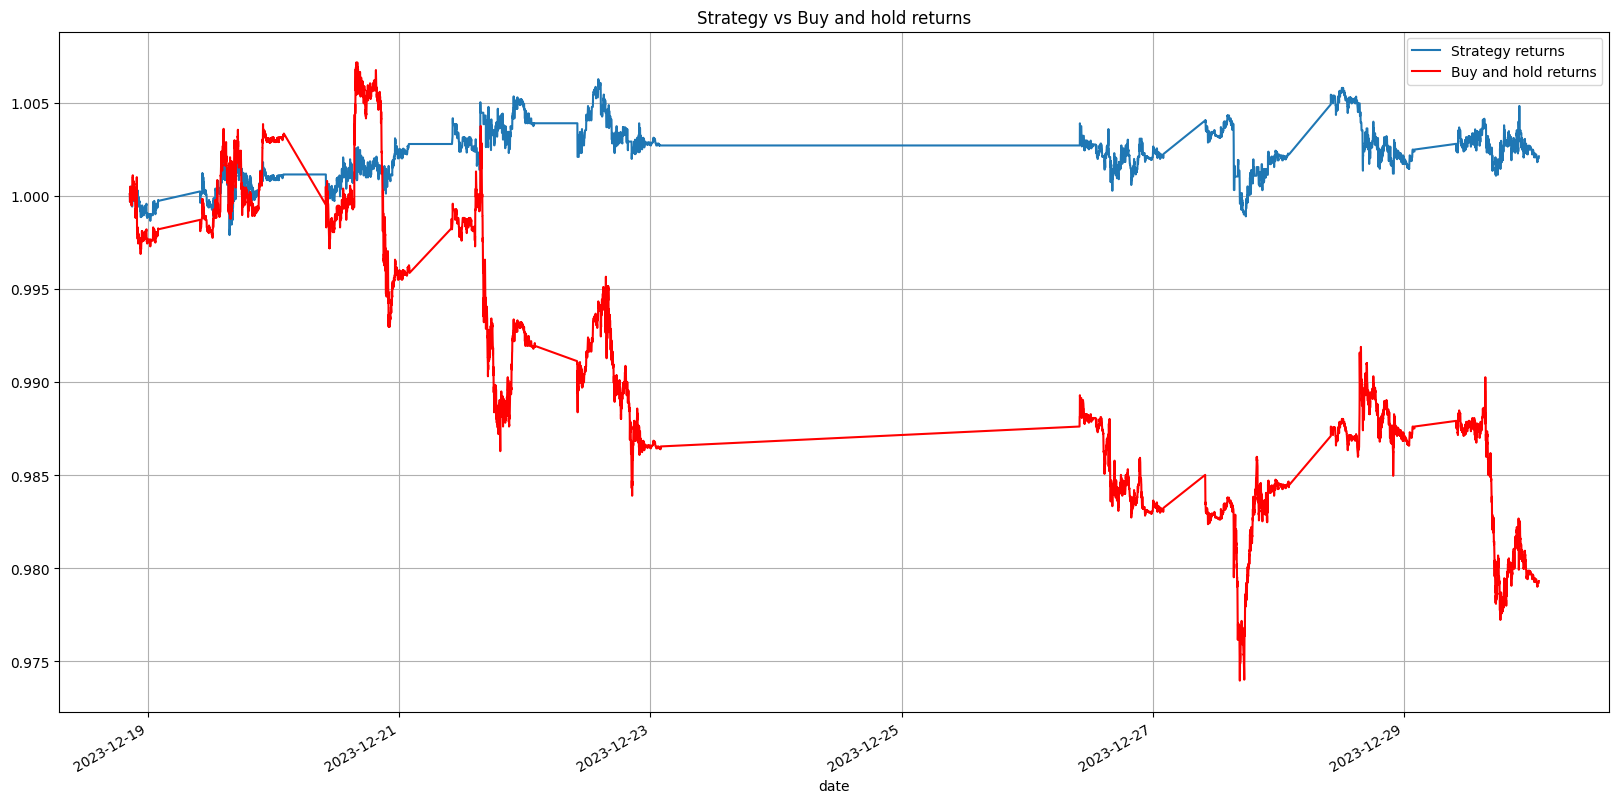

In [33]:
ax = (
    df["strategy_cum_returns"]
    .plot(figsize=(20, 10), grid=True, label="Strategy returns")
)
ax.plot(df["cum_returns"], color="red", label="Buy and hold returns")
ax.legend()
ax.set_title("Strategy vs Buy and hold returns")

In [34]:

print_portfolio_strategy_report(df.strategy_returns, df.returns, "1min")

,Portfolio,Benchmark
Expected return,0.1687,-1.524139
CAGR,0.162282,-0.788633
Expected volatility,0.146822,0.212058
Skewness,0.760415,0.334551
Kurtosis,32.913911,19.624075
VaR,-0.000305,-0.000416
CVaR,-0.000484,-0.000698
Max drawdown,-0.007329,-0.032989
Kelly criterion,0.003004,-0.016452
Profit factor,1.006426,0.966461


In [35]:
plot_from_trade_df(df)

Loading BokehJS ...